In [21]:
import pandas as pd
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: 讀取所有檔案並將它們載入至字典中，每個地點一個DataFrame
file_paths = glob.glob("/mnt/disk2/kuan/new_L*_Train.csv")  # 請替換為實際路徑
location_data = {f"L{idx + 1}": pd.read_csv(file) for idx, file in enumerate(file_paths)}

# 合併所有地點的數據
all_data = pd.concat(location_data.values(), ignore_index=True)

# 數據預處理
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'], format='mixed')

for col in ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 
            'Sunlight(Lux)', 'Power(mW)', 'Hour', 'Minute', 'Month', 
            'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
            'Month_sin', 'Month_cos', 'DayOfYear', 'DayOfYear_sin', 'DayOfYear_cos']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data.ffill(inplace=True)
all_data.bfill(inplace=True)
print("MinMaxScaler")

# MinMaxScaler()數據
scaler = StandardScaler()
columns_to_scale = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 
                    'Sunlight(Lux)', 'Power(mW)', 'Hour', 'Minute', 'Month']

all_data[columns_to_scale] = scaler.fit_transform(all_data[columns_to_scale])

print("One-Hot")
# One-Hot 編碼 LocationCode
encoder = OneHotEncoder(sparse_output=False)
location_codes_encoded = encoder.fit_transform(all_data[['LocationCode']])
location_code_columns = encoder.get_feature_names_out(['LocationCode'])
location_codes_df = pd.DataFrame(location_codes_encoded, columns=location_code_columns, index=all_data.index)
all_data = pd.concat([all_data, location_codes_df], axis=1)

# 初始化 X_train 和 y_train
X_train = []
y_train = []

averaged_data_list = []
print("concat")
# 對每個 LocationCode 的數據進行處理
import pandas as pd

# 確保 DateTime 是 datetime 格式
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])

# 對每個 LocationCode 的數據進行處理
averaged_data_list = []
for location, location_data in all_data.groupby('LocationCode'):
    location_data = location_data.sort_values(by='DateTime')
    
    # 確保 DateTime 設為索引
    location_data = location_data.set_index('DateTime')
    
    # 逐日處理
    for date, daily_data in location_data.groupby(location_data.index.date):
        # 篩選當天的最早和最晚時間
        start_time = daily_data.index.min()  # 當天的最早時間
        end_time = daily_data.index.max()    # 當天的最晚時間
        
        # 按照當天的最早到最晚時間範圍進行重採樣並計算平均
        daily_averaged_data = daily_data.loc[start_time:end_time].resample('10min').mean(numeric_only=True)
        
        # 加回 LocationCode 欄位
        daily_averaged_data['LocationCode'] = location
        
        # 重置索引
        daily_averaged_data = daily_averaged_data.reset_index()
        
        # 將結果添加到列表
        averaged_data_list.append(daily_averaged_data)


# 合併所有 LocationCode 的結果
final_averaged_data = pd.concat(averaged_data_list, ignore_index=True)
# final_averaged_data.to_csv("train.csv", index = None)

for location, location_data in final_averaged_data.groupby('LocationCode'):
    location_data = location_data.sort_values(by='DateTime')
    
    # 確保 DateTime 設為索引
    location_data = location_data.set_index('DateTime')
    averaged_data = location_data.reset_index()

    # 檢查是否有足夠的步長來生成訓練樣本
    if len(averaged_data) > 30 + 48:  # 確保有足夠的數據進行 30 步輸入和 48 步輸出
        for i in range(len(averaged_data) - 30 - 48):
            # 提取前 30 步的特徵作為輸入
            features = averaged_data.iloc[i:i+30][[
                'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)',
                'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)',
                'LocationCode_1.0', 'LocationCode_2.0', 'LocationCode_3.0', 'LocationCode_4.0',
                'LocationCode_7.0', 'LocationCode_6.0', 'LocationCode_7.0', 'LocationCode_8.0',
                'LocationCode_9.0', 'LocationCode_10.0', 'LocationCode_11.0', 'LocationCode_12.0',
                'LocationCode_13.0', 'LocationCode_14.0', 'LocationCode_17.0', 'LocationCode_16.0',
                'LocationCode_17.0', 'Hour', 'Minute', 'Month', 
                'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                'Month_sin', 'Month_cos', 'DayOfYear', 'DayOfYear_sin', 
                'DayOfYear_cos']].values
            valid = True  # 每次開始一個新的時間步，設置 valid 為 True
            # 遍歷其他 LocationCode，將相同時間點的特徵合併
            for other_location, other_location_data in final_averaged_data.groupby('LocationCode'):
                if other_location != location:
                    other_location_data = other_location_data.sort_values(by='DateTime')
                    other_location_data = other_location_data.set_index('DateTime')
                    
                    # 使用 .reindex() 對齊時間戳，若缺失則跳過
                    aligned_data = other_location_data.loc[averaged_data.iloc[i:i+30]['DateTime']].reset_index(drop=True)
                    
                    # 檢查是否有缺失值，若有缺失則跳過
                    if aligned_data.isnull().values.any():
                        valid = False
                        break
                    
                    # 合併來自其他 LocationCode 的特徵
                    features = np.hstack([features, aligned_data[['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)',
                'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)',
                'LocationCode_1.0', 'LocationCode_2.0', 'LocationCode_3.0', 'LocationCode_4.0',
                'LocationCode_7.0', 'LocationCode_6.0', 'LocationCode_7.0', 'LocationCode_8.0',
                'LocationCode_9.0', 'LocationCode_10.0', 'LocationCode_11.0', 'LocationCode_12.0',
                'LocationCode_13.0', 'LocationCode_14.0', 'LocationCode_17.0', 'LocationCode_16.0',
                'LocationCode_17.0', 'Hour', 'Minute', 'Month', 
                'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                'Month_sin', 'Month_cos', 'DayOfYear', 'DayOfYear_sin', 
                'DayOfYear_cos']].values])
            
            # 如果有缺失值則跳過這筆資料
            if not valid:
                continue
            
            # 將合併後的特徵添加到訓練資料
            X_train.append(features)

            # 提取未來 48 步的 Power(mW) 作為目標
            target = averaged_data.iloc[i+30:i+30+48]['Power(mW)'].values
            y_train.append(target)
print("done")
# 轉換成 NumPy 陣列
X_train = np.array(X_train)
y_train = np.array(y_train)

# 分割為訓練集、驗證集和測試集
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)




MinMaxScaler
One-Hot
concat


KeyError: "None of [DatetimeIndex(['2024-01-01 07:00:00', '2024-01-01 07:10:00',\n               '2024-01-01 07:20:00', '2024-01-01 07:30:00',\n               '2024-01-01 07:40:00', '2024-01-01 07:50:00',\n               '2024-01-01 08:00:00', '2024-01-01 08:10:00',\n               '2024-01-01 08:20:00', '2024-01-01 08:30:00',\n               '2024-01-01 08:40:00', '2024-01-01 08:50:00',\n               '2024-01-01 09:00:00', '2024-01-01 09:10:00',\n               '2024-01-01 09:20:00', '2024-01-01 09:30:00',\n               '2024-01-01 09:40:00', '2024-01-01 09:50:00',\n               '2024-01-01 10:00:00', '2024-01-01 10:10:00',\n               '2024-01-01 10:20:00', '2024-01-01 10:30:00',\n               '2024-01-01 10:40:00', '2024-01-01 10:50:00',\n               '2024-01-01 11:00:00', '2024-01-01 11:10:00',\n               '2024-01-01 11:20:00', '2024-01-01 11:30:00',\n               '2024-01-01 11:40:00', '2024-01-01 11:50:00'],\n              dtype='datetime64[ns]', name='DateTime', freq=None)] are in the [index]"

In [12]:
from model_transformer import TimeSeriesDataset, TransformerModel
train_dataset = TimeSeriesDataset(X_train_final, y_train_final)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

best_val_loss = float('inf')  # 用來記錄最佳的驗證損失
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_size=X_train.shape[2], hidden_size=256, output_size=48, num_heads=7)
model.to(device)

TransformerModel(
  (pos_encoder): Embedding(256, 35)
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=35, out_features=35, bias=True)
    )
    (linear1): Linear(in_features=35, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=35, bias=True)
    (norm1): LayerNorm((35,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((35,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=35, out_features=35, bias=True)
        )
        (linear1): Linear(in_features=35, out_features=2048, bias=True)
        (dropout): Dr

/tmp/ipykernel_1210199/2408548853.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model weights loaded from ./best_model3.pth


/mnt/disk2/kuan/aicup/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mnt/disk2/kuan/aicup/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10000], Loss: 0.3302, Val Loss: 0.3470
Epoch [2/10000], Loss: 0.3289, Val Loss: 0.3488
Epoch [3/10000], Loss: 0.3283, Val Loss: 0.3455
Epoch [4/10000], Loss: 0.3272, Val Loss: 0.3454
Epoch [5/10000], Loss: 0.3265, Val Loss: 0.3493
Epoch [6/10000], Loss: 0.3261, Val Loss: 0.3415
Epoch [7/10000], Loss: 0.3256, Val Loss: 0.3430
Epoch [8/10000], Loss: 0.3250, Val Loss: 0.3515
Epoch [9/10000], Loss: 0.3242, Val Loss: 0.3461
Epoch [10/10000], Loss: 0.3237, Val Loss: 0.3466
Epoch [11/10000], Loss: 0.3232, Val Loss: 0.3460
Epoch [12/10000], Loss: 0.3225, Val Loss: 0.3458
Epoch [13/10000], Loss: 0.3219, Val Loss: 0.3480
Epoch [14/10000], Loss: 0.3215, Val Loss: 0.3466
Epoch [15/10000], Loss: 0.3208, Val Loss: 0.3476
Epoch [16/10000], Loss: 0.3193, Val Loss: 0.3469
Early stopping at epoch 16
Test Loss: 0.3481
Mean Squared Error (MSE): 2.1032
Mean Absolute Error (MAE): 0.7410
Total Error: 379819.1834
First 1000 Actual vs. Predicted values:
       Actual  Predicted
0    4.766816   3.94350

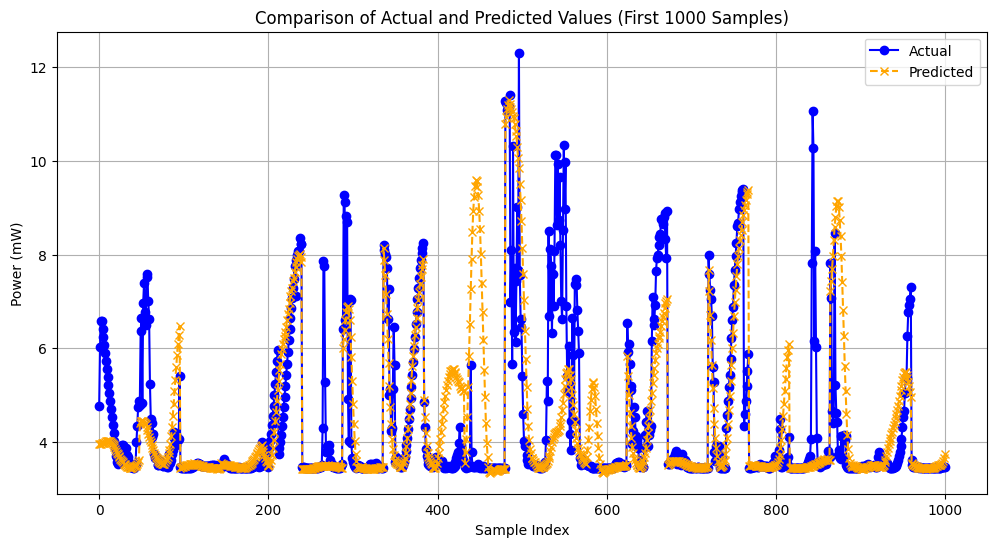

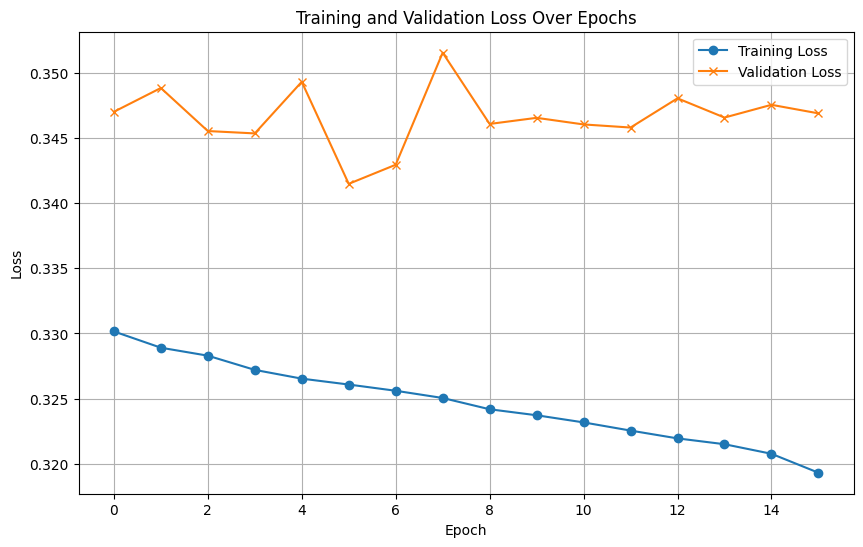

In [13]:

# Load pre-trained weights if available
model_path = "./best_model3.pth"
try:
    model.load_state_dict(torch.load(model_path))
    print(f"Model weights loaded from {model_path}")
except FileNotFoundError:
    print(f"No pre-trained weights found at {model_path}, starting training from scratch.")


criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Using CosineAnnealingLR for learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.1, verbose=True)
# Early Stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

training_loss = []
validation_loss = []
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    training_loss.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    epoch_val_loss = val_loss / len(val_loader)
    validation_loss.append(epoch_val_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "./best_model3.pth")  # Save model weights
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# ===========================
# Step 7: Evaluating the Model
# ===========================
model.eval()
test_loss = 0.0
predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        predictions.append(outputs.cpu().numpy())
        true_values.append(targets.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# ===========================
# Step 6: Plot Results
# ===========================
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# 反標準化
true_values_expanded = np.zeros((true_values.shape[0] * 48, 9))
true_values_expanded[:, -1] = true_values.flatten()

predictions_expanded = np.zeros((predictions.shape[0] * 48, 9))
predictions_expanded[:, -1] = predictions.flatten()

true_values_original = scaler.inverse_transform(true_values_expanded)[:, -1].reshape(true_values.shape)
predictions_original = scaler.inverse_transform(predictions_expanded)[:, -1].reshape(predictions.shape)

# Rescale Data
true_values_expanded = np.zeros((true_values.shape[0] * 48, 9))
true_values_expanded[:, -1] = true_values.flatten()

predictions_expanded = np.zeros((predictions.shape[0] * 48, 9))
predictions_expanded[:, -1] = predictions.flatten()


true_values_original = scaler.inverse_transform(true_values_expanded)[:, -1].reshape(true_values.shape)
predictions_original = scaler.inverse_transform(predictions_expanded)[:, -1].reshape(predictions.shape)
predictions_original = np.clip(predictions_original, a_min=0, a_max=None)

# Calculate MSE and MAE
mse = mean_squared_error(true_values_original.flatten(), predictions_original.flatten())
mae = mean_absolute_error(true_values_original.flatten(), predictions_original.flatten())
total_error = np.sum(np.abs(true_values_original.flatten() - predictions_original.flatten()))

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Total Error: {total_error:.4f}")

# Compare 30 actual and predicted values
comparison_data = pd.DataFrame({
    "Actual": true_values_original.flatten()[:1000],
    "Predicted": predictions_original.flatten()[:1000]
})
print("First 1000 Actual vs. Predicted values:")
print(comparison_data)

# Save the comparison to a CSV file for review
comparison_data.to_csv("comparison_data.csv", index=False)

# Plotting the results for the first 30 points
plt.figure(figsize=(12, 6))
plt.plot(true_values_original.flatten()[:1000], label="Actual", marker='o', linestyle="-", color="blue")
plt.plot(predictions_original.flatten()[:1000], label="Predicted", marker='x', linestyle="--", color="orange")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Power (mW)")
plt.title("Comparison of Actual and Predicted Values (First 1000 Samples)")
plt.grid(True)
plt.savefig("output_plot_1000_samples.png")
plt.show()




plt.figure(figsize=(10, 6))
plt.plot(training_loss, label="Training Loss", marker='o')
plt.plot(validation_loss, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# 儲存損失圖
plt.savefig("loss.png")
plt.show()


all_data = []

##### Predict
df_test = pd.read_csv("/mnt/disk2/kuan/test.csv")
df_test['day'] = pd.to_datetime(df_test['day'])
for i in range(1, 18):
    time_temp = df_test[(df_test['loc']) == i]

    # 假設訓練數據在 all_data 中，已按 DateTime 排序
    
    for date in time_temp['day']:

        # 選取 前天 的 7:00 ~ 17:00
        start_time_1 = date - pd.Timedelta(days=1)
        start_time_1 = start_time_1.replace(hour=7, minute=0, second=0)
        end_time_1 = start_time_1.replace(hour=17, minute=0, second=0)
        data_1 = final_averaged_data[(final_averaged_data['DateTime'] >= start_time_1) & 
                          (final_averaged_data['DateTime'] <= end_time_1)]
        # 選取 1/2 的 7:00 ~ 9:00
        start_time_2 = date
        start_time_2 = start_time_2.replace(hour=7, minute=0, second=0)
        end_time_2 = start_time_2.replace(hour=9, minute=0, second=0)
        data_2 = final_averaged_data[(final_averaged_data['DateTime'] >= start_time_2) & 
                         (final_averaged_data['DateTime'] <= end_time_2)]
    

        # 拼接數據
        input_data = pd.concat([data_1, data_2]).sort_values(by='DateTime')

        # 確保有 30 步數據
        if len(input_data) < 30:
            raise ValueError("輸入數據不足 30 步，請檢查時間範圍是否正確。")

        # 取前 30 步的特徵作為模型輸入
        input_features = input_data.iloc[-30:][[
                'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)',
                'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)',
                'LocationCode_1.0', 'LocationCode_2.0', 'LocationCode_3.0', 'LocationCode_4.0',
                'LocationCode_7.0', 'LocationCode_6.0', 'LocationCode_7.0', 'LocationCode_8.0',
                'LocationCode_9.0', 'LocationCode_10.0', 'LocationCode_11.0', 'LocationCode_12.0',
                'LocationCode_13.0', 'LocationCode_14.0', 'LocationCode_17.0', 'LocationCode_16.0',
                'LocationCode_17.0', 'Hour', 'Minute', 'Month', 
                'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos', 
                'Month_sin', 'Month_cos', 'DayOfYear', 'DayOfYear_sin', 
                'DayOfYear_cos']].values

        # 將特徵縮放
        # input_features = scaler.transform(input_features)

        # 轉換為 NumPy 陣列，並增加 batch 維度
        input_features = np.expand_dims(input_features, axis=0)  # (1, 30, feature_dim)

        # 將數據轉為 PyTorch tensor
        input_tensor = torch.tensor(input_features, dtype=torch.float32).to(device)
        # print(input_tensor.shape)

        # 模型進行預測
        model.eval()
        with torch.no_grad():
            predictions = model(input_tensor)

        # 將預測值轉為 NumPy，並放置到對應欄位
        predictions_np = predictions.cpu().numpy()  # 將 Tensor 轉為 NumPy 陣列
        # print(predictions_np.shape)
        if predictions_np.ndim:
            predictions_np = predictions_np.flatten()  # 或 predictions_np = predictions_np.squeeze()

        predictions_expanded = np.zeros((len(predictions_np), len(columns_to_scale)))

        # 填充 'Power(mW)' 列
        power_index = columns_to_scale.index('Power(mW)')
        predictions_expanded[:, power_index] = predictions_np

        # 進行反標準化
        predictions_original = scaler.inverse_transform(predictions_expanded)

        # 提取反標準化後的 'Power(mW)' 預測值
        power_predictions_original = predictions_original[:, power_index]

        ### 做時間
        time_stamps = [date.replace(hour=9, minute=0) + pd.Timedelta(minutes=10 * i) for i in range(48)]
        for j, ts in enumerate(time_stamps):
            # 格式化時間戳為 YYYYMMDDHHMM
            time_str = ts.strftime('%Y%m%d%H%M')
            location_code = f"{i:02d}"  # 假設地點代碼循環

            # 創建帶有地點的時間戳
            time_with_location = time_str + location_code

            # 將結果加入到 DataFrame
            all_data.append({'序號': time_with_location, '答案': power_predictions_original[j]})


        # all_data.append(df_output)


final_df = pd.DataFrame(all_data)
final_df['答案'] = np.maximum(final_df['答案'], 0)

# 保存為 CSV
final_df.to_csv("789.csv", index=False)

In [20]:
averaged_data.shape

(7760, 37)